In [ ]:
pip install seaborn matplotlib

In [ ]:
import keras
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn import svm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from keras.models import Sequential
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras. layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split, cross_val_score
from keras.layers import Conv1D, MaxPooling2D, MaxPooling1D, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
  pass
  warnings.warn=ignore_warn

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=98

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Final_Dataset(RLDD)",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1850 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterial_leaf_blight',
 'Brown_spot',
 'Healthy_leaf',
 'Leaf_Blast',
 'Other',
 'Tungro']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[5 4 0 3 2 2 1 3 2 5 0 4 4 1 4 4 3 2 2 4 3 5 2 3 1 1 2 2 1 2 4 2]


In [ ]:
len(dataset)

58

In [ ]:
new_image_size = (256, 256)
resized_dataset = dataset.map(lambda x, y: (tf.image.resize(x, new_image_size), y))
for image_batch, labels_batch in resized_dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


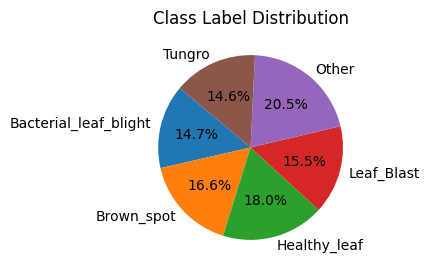

In [ ]:
# Create a list to store the count of each class label
class_counts = [0] * len(class_names)
for images_batch, labels_batch in resized_dataset:
    for label in labels_batch:
        class_counts[label] += 1

plt.figure(figsize=(3, 3))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Class Label Distribution")
plt.show()

**Visualize some of the images from our datasetmodel**

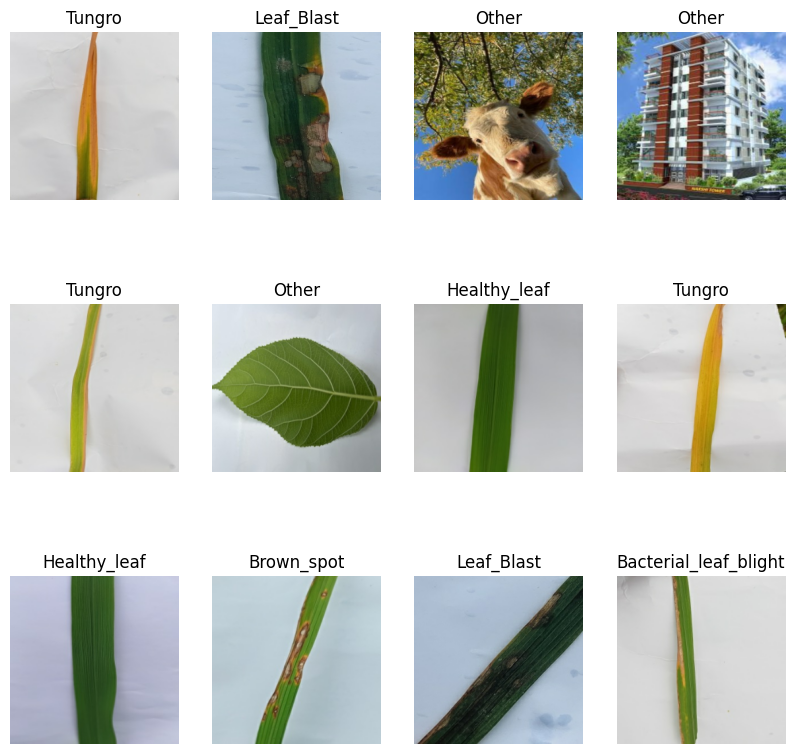

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in resized_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  #print(image_batch[0].shape)

Function to Split Dataset Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training Validation: Dataset to be tested against while training Test: Dataset to be tested against after we trained a model

In [ ]:
train_size = 0.8
len(resized_dataset)*train_size

46.400000000000006

In [ ]:
train_ds= resized_dataset.take(46)
len(train_ds)

46

In [ ]:
test_ds = resized_dataset.skip(46)
len(test_ds)

12

In [ ]:
val_size = 0.1
len(resized_dataset)*val_size

5.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)
      train_size = int(train_split * ds_size)
      val_size = int(val_split * ds_size)
      train_ds = ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)
      return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(resized_dataset)

In [ ]:
len(train_ds)

46

In [ ]:
len(val_ds)

5

In [ ]:
len(test_ds)

7

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",dtype=tf.float32),  # Explicitly set data type
    # ... other preprocessing layers
  layers.experimental.preprocessing.RandomRotation(0.2),
  #layers.experimental.preprocessing.RandomZoom(0.1),
  #layers.experimental.preprocessing.RandomContrast(0.2),
])

Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Build Custom CNN model

Model Architecture We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, 256, 256, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #base_cnn,  # Pre-trained VGG16 CNN layers
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

Compiling the Model We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/98
46/46 [==============================] - 21s 449ms/step - loss: 1.6401 - accuracy: 0.2729 - val_loss: 1.2091 - val_accuracy: 0.5000
Epoch 2/98
46/46 [==============================] - 14s 314ms/step - loss: 1.1414 - accuracy: 0.5389 - val_loss: 0.7737 - val_accuracy: 0.7063
Epoch 3/98
46/46 [==============================] - 14s 311ms/step - loss: 0.8345 - accuracy: 0.6733 - val_loss: 0.7432 - val_accuracy: 0.7437
Epoch 4/98
46/46 [==============================] - 15s 314ms/step - loss: 0.7249 - accuracy: 0.7101 - val_loss: 0.5080 - val_accuracy: 0.8313
Epoch 5/98
46/46 [==============================] - 14s 314ms/step - loss: 0.6499 - accuracy: 0.7708 - val_loss: 0.5832 - val_accuracy: 0.7812
Epoch 6/98
46/46 [==============================] - 17s 362ms/step - loss: 0.6498 - accuracy: 0.7626 - val_loss: 0.6885 - val_accuracy: 0.8062
Epoch 7/98
46/46 [==============================] - 14s 292ms/step - loss: 0.5763 - accuracy: 0.7879 - val_loss: 0.8102 - val_accuracy: 0.7625

In [ ]:
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

7/7 [==============================] - 4s 27ms/step - loss: 0.0454 - accuracy: 0.9866
Test Accuracy: 98.66%


In [ ]:
history.params

{'verbose': 1, 'epochs': 98, 'steps': 46}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
len(history.history['loss'])

98

In [ ]:
history.history['loss'][:15] # show loss for first 15 epochs

[1.6400812864303589,
 1.141448736190796,
 0.8345192074775696,
 0.7249239683151245,
 0.6498512625694275,
 0.6498292088508606,
 0.5762694478034973,
 0.571114182472229,
 0.48825913667678833,
 0.4332207441329956,
 0.4033305048942566,
 0.41224926710128784,
 0.32151710987091064,
 0.3849419057369232,
 0.3950079679489136]

Plotting the Accuracy and Loss Curves

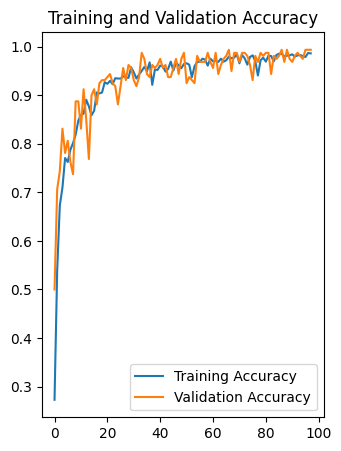

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

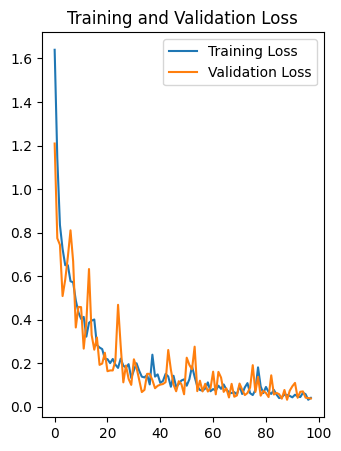

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Confusion Matrix

In [ ]:
# Make predictions using the model
predictions = model.predict(test_ds)
# Get the predicted class labels
predicted_labels = [np.argmax(prediction) for prediction in predictions]
test_labels = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())
test_labels = np.array(test_labels)
confusion = confusion_matrix(test_labels, predicted_labels)

print("Confusion Matrix:")
print(confusion)

7/7 [==============================] - 0s 24ms/step
Confusion Matrix:
[[ 8  2  6  5  3  6]
 [ 2 16  2  7  9  6]
 [ 6  2 12  6 12  5]
 [ 6  7  6  7  3  4]
 [ 3  9 11  3 13  3]
 [ 5  6  6  4  3 10]]


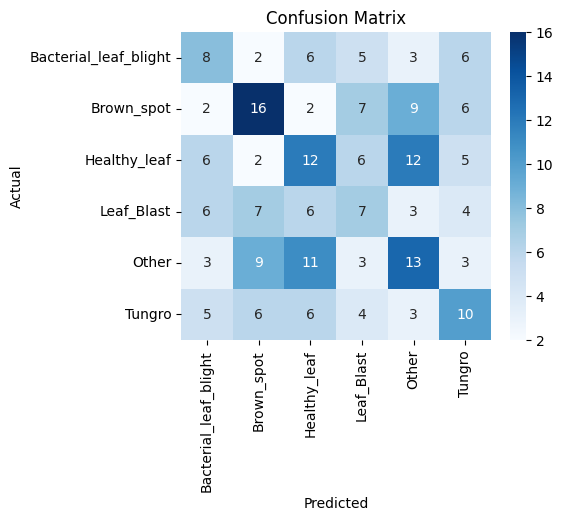

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to display the confusion matrix
plot_confusion_matrix(confusion, class_names)

In [ ]:
from sklearn.metrics import classification_report
test_labels = []  # True labels
predicted_labels = []  # Predicted labels

for images_batch, labels_batch in test_ds:
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))
    test_labels.extend(labels_batch.numpy())
report = classification_report(test_labels, predicted_labels, target_names=class_names)
print(report)

1/1 [==============================] - 0s 34ms/step
                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.97      0.97      0.97        30
           Brown_spot       1.00      1.00      1.00        42
         Healthy_leaf       1.00      1.00      1.00        43
           Leaf_Blast       1.00      0.97      0.98        33
                Other       0.98      1.00      0.99        42
               Tungro       0.97      0.97      0.97        34

             accuracy                           0.99       224
            macro avg       0.99      0.98      0.99       224
         weighted avg       0.99      0.99      0.99       224



Run prediction on a sample image

first image to predict
actual label: Healthy_leaf
1/1 [==============================] - 0s 41ms/step
predicted label: Healthy_leaf


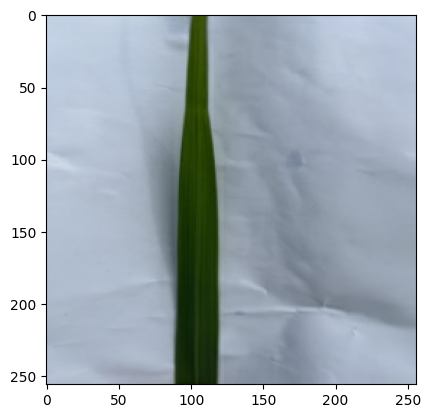

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


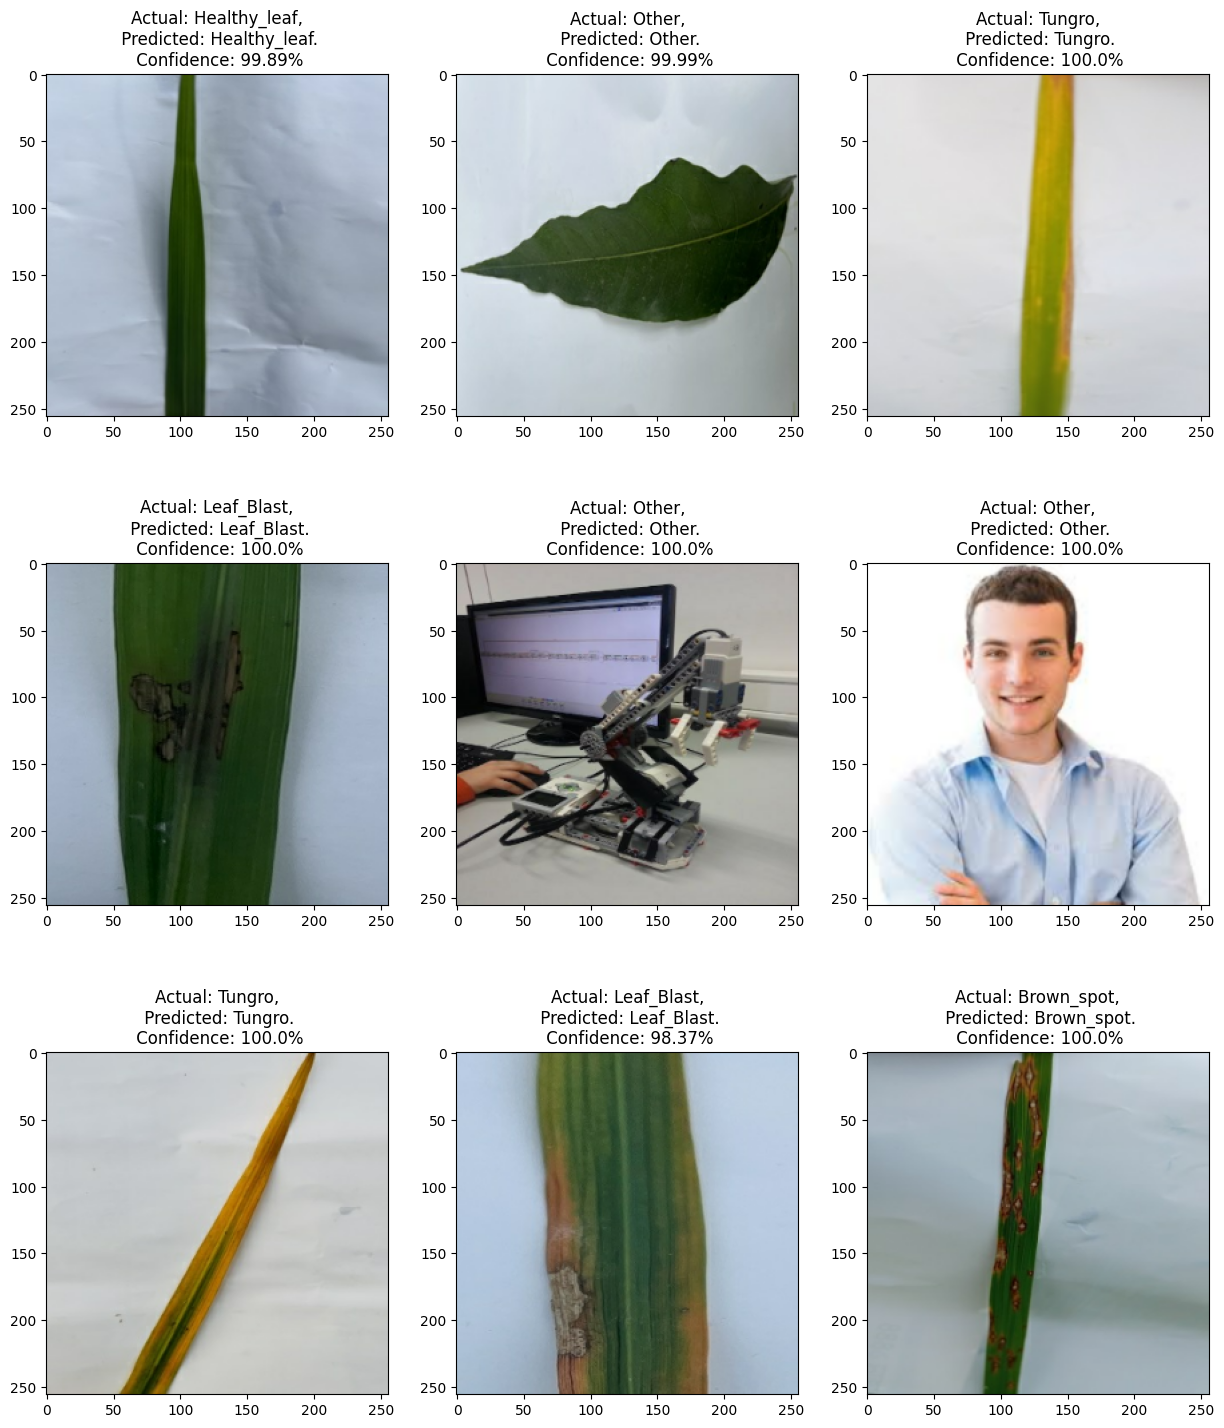

In [ ]:
plt.figure(figsize=(15, 18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        #plt.axis("off")

Saved Tensorflow Model

In [ ]:
model.save('/content/drive/MyDrive/12_98')

tflite model save

In [ ]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model-2.tflite', 'wb') as f:
    f.write(tflite_model)

CNN_SVM Hybrid Model

In [ ]:
# Extract features using the trained CNN model
def extract_features(model, dataset):
    feature_list = []
    label_list = []
    for images, labels in dataset:
        features = model.predict(images)
        feature_list.append(features)
        label_list.append(labels)

    return np.vstack(feature_list), np.concatenate(label_list)

In [ ]:
# Use the trained CNN model to extract features
train_features, train_labels = extract_features(model, train_ds)
val_features, val_labels = extract_features(model, val_ds)
test_features, test_labels = extract_features(model, test_ds)

# Flatten the features for SVM
train_features_flatten = train_features.reshape(train_features.shape[0], -1)
val_features_flatten = val_features.reshape(val_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

# Train SVM classifier
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(train_features_flatten, train_labels)

1/1 [==============================] - 0s 29ms/step


SVC(kernel='linear')

In [ ]:
# Make predictions on validation set
val_predictions = svm_classifier.predict(val_features_flatten)
accuracy = accuracy_score(val_labels, val_predictions)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Make predictions on test set
test_predictions = svm_classifier.predict(test_features_flatten)
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 99.38%
Test Accuracy: 99.11%


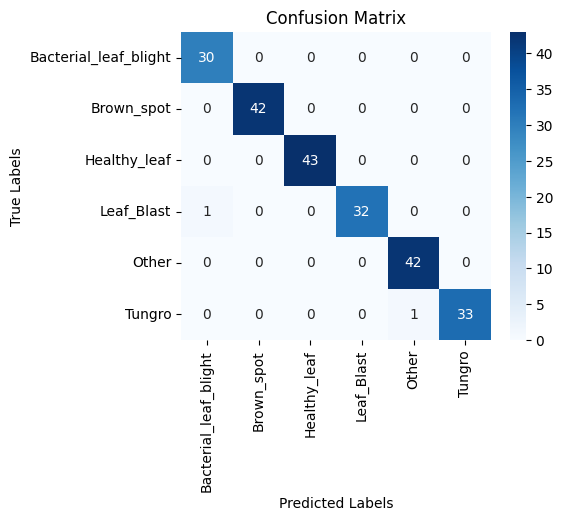

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plotting the Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Classification Report
class_report = classification_report(test_labels, test_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.97      1.00      0.98        30
           Brown_spot       1.00      1.00      1.00        42
         Healthy_leaf       1.00      1.00      1.00        43
           Leaf_Blast       1.00      0.97      0.98        33
                Other       0.98      1.00      0.99        42
               Tungro       1.00      0.97      0.99        34

             accuracy                           0.99       224
            macro avg       0.99      0.99      0.99       224
         weighted avg       0.99      0.99      0.99       224

